# Backtester Analysis & Orchestration

A Jupyter notebook for orchestrating backtester runs and analyzing results.

**Uses pyproject.toml dependencies** with `[backtest]` extras for analysis libraries.

# 1. Setup & Imports

Configure environment, imports, and project paths.

In [22]:
from pathlib import Path
import sys
import os
import json
from datetime import datetime

# Detect Colab
IN_COLAB = "google.colab" in sys.modules or "COLAB_GPU" in os.environ

PROJECT_ROOT = None

if IN_COLAB:
    import subprocess
    colab_root = Path("/content/temp-data-pipeline")
    if not (colab_root / "pyproject.toml").exists():
        # Clone repo if not present
        subprocess.run(
            ["git", "clone", "https://github.com/kyler505/temp-data-pipeline.git", str(colab_root)],
            check=True,
        )
    else:
        # Pull latest changes
        subprocess.run(["git", "pull"], cwd=colab_root, check=True)
    PROJECT_ROOT = colab_root
else:
    # Local: search upward for pyproject.toml
    cwd = Path.cwd().resolve()
    for parent in [cwd] + list(cwd.parents):
        if (parent / "pyproject.toml").exists():
            PROJECT_ROOT = parent
            break
    # Fallback to common dev location
    if PROJECT_ROOT is None:
        candidate = Path.home() / "Documents" / "temp-data-pipeline"
        if (candidate / "pyproject.toml").exists():
            PROJECT_ROOT = candidate

if PROJECT_ROOT is None:
    raise FileNotFoundError("Could not find project root. Set PROJECT_ROOT manually.")

# Add to Python path
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
src_path = PROJECT_ROOT / "src"
if src_path.exists() and str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

# Import analysis dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown, HTML

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print(f"Project root: {PROJECT_ROOT}")
print(f"Environment: {'Colab' if IN_COLAB else 'Local'}")
print(f"Python path includes src: {src_path in sys.path}")

Project root: /Users/kcao/Documents/temp-data-pipeline
Environment: Local
Python path includes src: False


## Install packages

Install project dependencies in editable mode with backtest extras.

In [23]:
import sys
import subprocess
import importlib

# Always reinstall in editable mode to pick up any code changes
# Include backtest extras for analysis dependencies
if (PROJECT_ROOT / "pyproject.toml").exists():
    subprocess.run(
        [sys.executable, "-m", "pip", "install", "-q", "-e", f"{PROJECT_ROOT}[backtest]"],
        check=True,
    )
    # Clear cached imports so we get the latest code
    for mod_name in list(sys.modules.keys()):
        if mod_name.startswith("tempdata"):
            del sys.modules[mod_name]
    print("Installed/updated tempdata[backtest] in editable mode")
else:
    raise FileNotFoundError(
        f"pyproject.toml not found in {PROJECT_ROOT}. "
        "Update PROJECT_ROOT in the setup cell."
    )

Installed/updated tempdata[backtest] in editable mode


# 3. Select Config + Run ID

Choose a configuration file and run identifier.

**Note:** This cell defines the parameters for the backtest run. Change these values to experiment with different configurations.

In [24]:
# Configuration selection
CONFIG_PATH = "configs/bt_klga_baseline.json"  # Path to config file

# Run identifier (leave empty for auto-generated)
RUN_ID = None  # Or None for timestamp-based ID

# Alternative configs for comparison
CONFIGS = {
    "baseline": "configs/bt_klga_baseline.json",
    "aggressive": "configs/bt_klga_aggressive.json",
}

# Validate config exists
config_file = PROJECT_ROOT / CONFIG_PATH
if not config_file.exists():
    print(f"⚠️  Config file not found: {config_file}")
    print("Available configs:", list(PROJECT_ROOT.glob("configs/*.json")))
else:
    print(f"✅ Config selected: {CONFIG_PATH}")

print(f"Run ID: {RUN_ID or 'auto-generated'}")

✅ Config selected: configs/bt_klga_baseline.json
Run ID: auto-generated


# 4. Run Backtester

All backtester logic lives in the Python modules. This notebook only orchestrates execution.

**Options:**
- Option A: CLI invocation (recommended)
- Option B: Python API (if available)

In [25]:
# Option A: CLI invocation (recommended)
import subprocess

# Load config and build command arguments
with open(PROJECT_ROOT / CONFIG_PATH) as f:
    config_data = json.load(f)

# Build command with individual arguments
cmd = [
    "python",
    "scripts/backtest_daily_tmax.py",
    "--station", config_data["station_ids"][0],  # Use first station
    "--start", config_data["start_date_local"],
    "--end", config_data["end_date_local"],
    "--min-coverage", str(config_data["min_coverage_hours"]),
    "--model-type", config_data["model_type"],
    "--model-alpha", str(config_data["model_alpha"]),
    "--sigma-type", config_data["sigma_type"],
    "--sigma-floor", str(config_data["sigma_floor"]),
    "--edge-min", str(config_data["edge_min"]),
    "--max-per-market", str(config_data["max_per_market_pct"]),
    "--max-total", str(config_data["max_total_pct"]),
    "--slippage", str(config_data["slippage"]),
    "--initial-bankroll", str(config_data["initial_bankroll"]),
    "--price-type", config_data["price_type"],
    "--price-noise", str(config_data["price_noise"]),
    "--train-frac", str(config_data["train_frac"]),
    "--val-frac", str(config_data["val_frac"]),
    "--seed", str(config_data["random_seed"]),
]

if RUN_ID:
    cmd.extend(["--run-id", RUN_ID])

# Handle lead hours if specified
if config_data.get("lead_hours_allowed"):
    lead_hours_str = ",".join(str(h) for h in config_data["lead_hours_allowed"])
    cmd.extend(["--lead-hours", lead_hours_str])

# Add any additional CLI args here
# cmd.extend(["--quiet"])

print(f"Running: {' '.join(cmd)}")
print(f"Working directory: {PROJECT_ROOT}")
print(f"Config: {CONFIG_PATH}")

# Execute
result = subprocess.run(cmd, cwd=PROJECT_ROOT, capture_output=True, text=True)

print("\nSTDOUT:")
print(result.stdout)

if result.stderr:
    print("\nSTDERR:")
    print(result.stderr)

if result.returncode == 0:
    print(f"\n✅ Backtest completed successfully")
    run_dir = PROJECT_ROOT / "runs" / (RUN_ID or "latest")
    if run_dir.exists():
        print(f"Artifacts: {run_dir}")
else:
    print(f"\n❌ Backtest failed with return code {result.returncode}")

Running: python scripts/backtest_daily_tmax.py --station KLGA --start 2020-01-01 --end 2024-12-31 --min-coverage 18 --model-type ridge --model-alpha 1.0 --sigma-type bucketed --sigma-floor 1.0 --edge-min 0.03 --max-per-market 0.02 --max-total 0.25 --slippage 0.01 --initial-bankroll 10000.0 --price-type synthetic --price-noise 0.05 --train-frac 0.7 --val-frac 0.15 --seed 42
Working directory: /Users/kcao/Documents/temp-data-pipeline
Config: configs/bt_klga_baseline.json

STDOUT:

DAILY TMAX BACKTEST: 20260119_143143
Station: KLGA
Date range: 2020-01-01 to 2024-12-31

[backtest] Loading data...

BACKTEST DATA SUMMARY

Data source: joined
  Forecast rows input: 2,796
  Truth rows input: 3,527
  Rows after join: 2,796
  Rows after filters: 1,827

Date range:
  Min target date: 2020-01-01 00:00:00
  Max target date: 2024-12-31 00:00:00

Stations: ['KLGA']
Lead hours: [28, 29]

Split sizes:
  Train: 1,278 rows (70.0%)
  Val:   274 rows (15.0%)
  Test:  275 rows (15.1%)

[backtest] Fitting fo

# 5. Load Run Artifacts

**Read-only operations only.** This cell loads artifacts from the completed run.

All data loaded here is immutable - treat run directories as historical records.

In [26]:
# Determine run directory
if RUN_ID:
    run_dir = PROJECT_ROOT / "runs" / RUN_ID
else:
    # Find most recent run
    runs_dir = PROJECT_ROOT / "runs"
    if runs_dir.exists():
        run_dirs = [d for d in runs_dir.iterdir() if d.is_dir()]
        if run_dirs:
            run_dir = max(run_dirs, key=lambda d: d.stat().st_mtime)
            RUN_ID = run_dir.name
        else:
            raise FileNotFoundError("No run directories found")
    else:
        raise FileNotFoundError("Runs directory not found")

print(f"Loading run: {RUN_ID}")
print(f"Run directory: {run_dir}")

# Load artifacts
config_path = run_dir / "config.json"
metrics_path = run_dir / "metrics.json"
trades_path = run_dir / "trades.parquet"
daily_path = run_dir / "daily_results.parquet"
predictions_path = run_dir / "predictions.parquet"

# Check what files exist
existing_files = [f for f in [config_path, metrics_path, trades_path, daily_path, predictions_path] if f.exists()]
print(f"Found artifacts: {[f.name for f in existing_files]}")

# Load configuration
with open(config_path) as f:
    config = json.load(f)

# Load metrics
with open(metrics_path) as f:
    metrics = json.load(f)

# Load DataFrames (if they exist)
trades_df = pd.read_parquet(trades_path) if trades_path.exists() else None
daily_df = pd.read_parquet(daily_path) if daily_path.exists() else None
predictions_df = pd.read_parquet(predictions_path) if predictions_path.exists() else None

print(f"\n✅ Loaded run {RUN_ID}")
print(f"Config: {config.get('model_type', 'unknown')} model, {config.get('station_ids', [])} stations")
print(f"Date range: {config.get('start_date_local')} to {config.get('end_date_local')}")

if predictions_df is not None:
    print(f"Predictions: {len(predictions_df)} samples")
if trades_df is not None:
    print(f"Trades: {len(trades_df)} trades")
if daily_df is not None:
    print(f"Daily results: {len(daily_df)} days")

# ==========================================
# FIXES FOR ANALYSIS COMPATIBILITY
# ==========================================
if daily_df is not None:
    # 1. Ensure 'date' column exists
    if 'target_date_local' in daily_df.columns and 'date' not in daily_df.columns:
        daily_df['date'] = pd.to_datetime(daily_df['target_date_local'])

    # 2. Calculate bankroll_end if missing
    if 'bankroll_end' not in daily_df.columns and 'total_pnl' in daily_df.columns:
        initial_bankroll = config.get('initial_bankroll', 10000.0)
        daily_df = daily_df.sort_values('date')
        daily_df['cumulative_pnl'] = daily_df['total_pnl'].cumsum()
        daily_df['bankroll_end'] = initial_bankroll + daily_df['cumulative_pnl']

    # 3. Calculate drawdown if missing
    if 'drawdown' not in daily_df.columns and 'bankroll_end' in daily_df.columns:
        daily_df['peak'] = daily_df['bankroll_end'].cummax()
        daily_df['drawdown'] = daily_df['peak'] - daily_df['bankroll_end']

if predictions_df is not None:
    # 4. Alias sigma
    if 'sigma_f' in predictions_df.columns and 'sigma' not in predictions_df.columns:
        predictions_df['sigma'] = predictions_df['sigma_f']

    # 5. Calculate residual
    if 'residual' not in predictions_df.columns and 'tmax_actual_f' in predictions_df.columns:
        predictions_df['residual'] = predictions_df['mu_f'] - predictions_df['tmax_actual_f']

    print(f"Applied compatibility fixes: added date, bankroll_end, drawdown, sigma, residual columns")

# ==========================================
# FIXES FOR ANALYSIS COMPATIBILITY - V2
# ==========================================
if daily_df is not None:
    # 1. Ensure 'date' column exists
    if 'target_date_local' in daily_df.columns and 'date' not in daily_df.columns:
        daily_df['date'] = pd.to_datetime(daily_df['target_date_local'])

    # 2. Calculate bankroll_end if missing
    if 'bankroll_end' not in daily_df.columns and 'total_pnl' in daily_df.columns:
        initial_bankroll = config.get('initial_bankroll', 10000.0)
        daily_df = daily_df.sort_values('date')
        daily_df['cumulative_pnl'] = daily_df['total_pnl'].cumsum()
        daily_df['bankroll_end'] = initial_bankroll + daily_df['cumulative_pnl']

    # 3. Calculate drawdown if missing
    if 'drawdown' not in daily_df.columns and 'bankroll_end' in daily_df.columns:
        daily_df['peak'] = daily_df['bankroll_end'].cummax()
        daily_df['drawdown'] = daily_df['peak'] - daily_df['bankroll_end']

if predictions_df is not None:
    # 4. Alias sigma
    if 'sigma_f' in predictions_df.columns and 'sigma' not in predictions_df.columns:
        predictions_df['sigma'] = predictions_df['sigma_f']

    # 5. Calculate residual
    if 'residual' not in predictions_df.columns and 'tmax_actual_f' in predictions_df.columns:
        predictions_df['mu_f'] = pd.to_numeric(predictions_df['mu_f'], errors='coerce')
        predictions_df['tmax_actual_f'] = pd.to_numeric(predictions_df['tmax_actual_f'], errors='coerce')
        predictions_df['residual'] = predictions_df['mu_f'] - predictions_df['tmax_actual_f']

    # 6. Calculate MAE and RMSE columns (required for monthly aggregation)
    if 'residual' in predictions_df.columns:
        if 'mae' not in predictions_df.columns:
            predictions_df['mae'] = predictions_df['residual'].abs()
        if 'rmse' not in predictions_df.columns:
            predictions_df['rmse'] = predictions_df['residual'] ** 2

    print(f"Applied V2 compatibility fixes: added date, bankroll_end, drawdown, sigma, residual, mae, rmse columns")


Loading run: 20260119_143143
Run directory: /Users/kcao/Documents/temp-data-pipeline/runs/20260119_143143
Found artifacts: ['config.json', 'metrics.json', 'trades.parquet', 'daily_results.parquet', 'predictions.parquet']

✅ Loaded run 20260119_143143
Config: ridge model, ['KLGA'] stations
Date range: 2020-01-01 to 2024-12-31
Predictions: 275 samples
Trades: 6 trades
Daily results: 4 days
Applied compatibility fixes: added date, bankroll_end, drawdown, sigma, residual columns
Applied V2 compatibility fixes: added date, bankroll_end, drawdown, sigma, residual, mae, rmse columns


# 6. Core Analysis Blocks

## A. Forecast Performance

Analyze forecast accuracy, calibration, and residuals.

FORECAST PERFORMANCE SUMMARY
Samples:      275
MAE:          1.00°F
RMSE:         1.24°F
Bias:         +0.25°F
90% PI cov:   94.5%


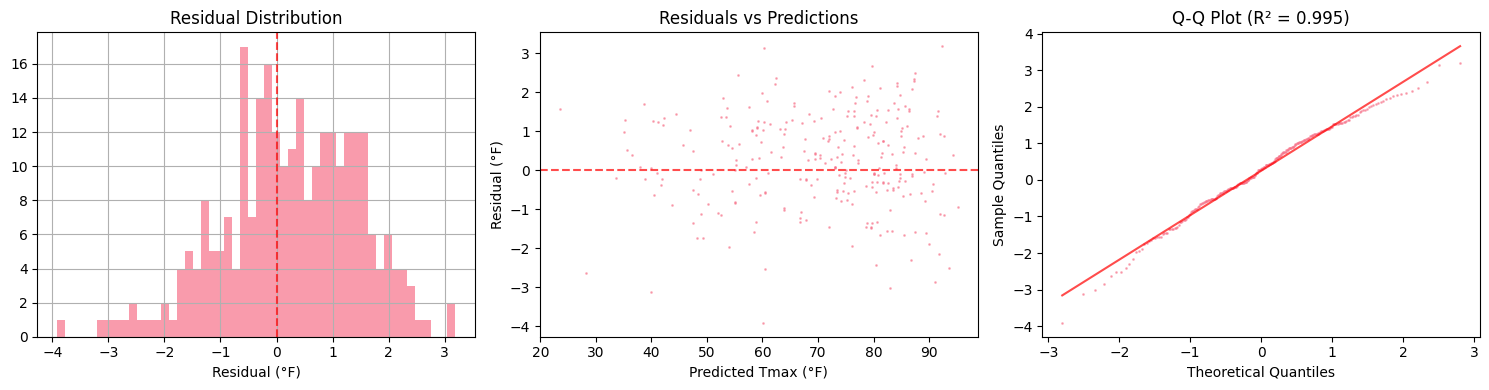

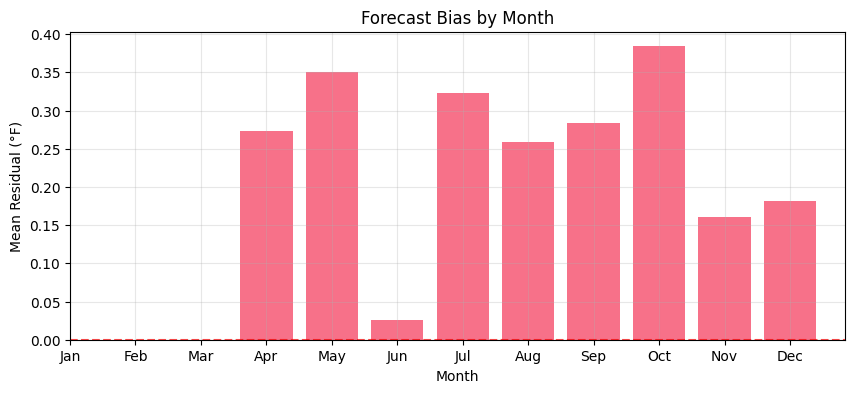

,mean,count
month,,
4,0.273,30
5,0.350,31
6,0.026,30
7,0.323,31
8,0.259,31
9,0.284,30
10,0.384,31
11,0.161,30
12,0.181,31


In [27]:
# Forecast performance summary
if 'forecast' in metrics:
    fc = metrics['forecast']
    print("=" * 50)
    print("FORECAST PERFORMANCE SUMMARY")
    print("=" * 50)
    print(f"Samples:      {fc.get('n_samples', 'N/A'):,}")
    print(f"MAE:          {fc.get('mae', 'N/A'):.2f}°F")
    print(f"RMSE:         {fc.get('rmse', 'N/A'):.2f}°F")
    print(f"Bias:         {fc.get('bias', 'N/A'):+.2f}°F")
    print(f"90% PI cov:   {fc.get('coverage_90', 'N/A'):.1%}")
    print("=" * 50)

# Compute residual if needed
if predictions_df is not None and 'mu_f' in predictions_df.columns and 'tmax_actual_f' in predictions_df.columns:
    predictions_df['residual'] = predictions_df['mu_f'] - predictions_df['tmax_actual_f']

# Residual analysis
if predictions_df is not None and 'residual' in predictions_df.columns:
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # Residual distribution
    predictions_df['residual'].hist(bins=50, ax=axes[0], alpha=0.7)
    axes[0].axvline(0, color='red', linestyle='--', alpha=0.7)
    axes[0].set_title('Residual Distribution')
    axes[0].set_xlabel('Residual (°F)')

    # Residuals vs predictions
    if 'mu_f' in predictions_df.columns:
        axes[1].scatter(predictions_df['mu_f'], predictions_df['residual'], alpha=0.5, s=1)
        axes[1].set_xlabel('Predicted Tmax (°F)')
    axes[1].axhline(0, color='red', linestyle='--', alpha=0.7)
    axes[1].set_title('Residuals vs Predictions')

    axes[1].set_ylabel('Residual (°F)')

    # QQ plot approximation
    from scipy import stats
    residuals = predictions_df['residual'].dropna()
    if len(residuals) > 10:
        (osm, osr), (slope, intercept, r) = stats.probplot(residuals, dist="norm")
        axes[2].scatter(osm, osr, alpha=0.5, s=1)
        axes[2].plot(osm, slope*osm + intercept, 'r-', alpha=0.7)
        axes[2].set_title(f'Q-Q Plot (R² = {r:.3f})')
        axes[2].set_xlabel('Theoretical Quantiles')
        axes[2].set_ylabel('Sample Quantiles')

    plt.tight_layout()
    plt.show()

# Bias by month
if predictions_df is not None and 'target_date_local' in predictions_df.columns and 'residual' in predictions_df.columns:
    predictions_df['month'] = pd.to_datetime(predictions_df['target_date_local']).dt.month
    monthly_bias = predictions_df.groupby('month')['residual'].agg(['mean', 'count']).round(3)

    plt.figure(figsize=(10, 4))
    plt.bar(monthly_bias.index, monthly_bias['mean'])
    plt.axhline(0, color='red', linestyle='--', alpha=0.7)
    plt.title('Forecast Bias by Month')
    plt.xlabel('Month')
    plt.ylabel('Mean Residual (°F)')
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.grid(True, alpha=0.3)
    plt.show()

    display(monthly_bias)

## B. Calibration Analysis

Analyze prediction interval coverage and calibration.

/var/folders/0b/0y3bh7ms71q9jngg8xbwy36h0000gn/T/ipykernel_61926/4250196592.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  reliability = predictions_df.groupby('error_bin')['sigma'].mean()
/var/folders/0b/0y3bh7ms71q9jngg8xbwy36h0000gn/T/ipykernel_61926/4250196592.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_levels = predictions_df.groupby('error_bin')['residual'].apply(lambda x: np.abs(x).mean())


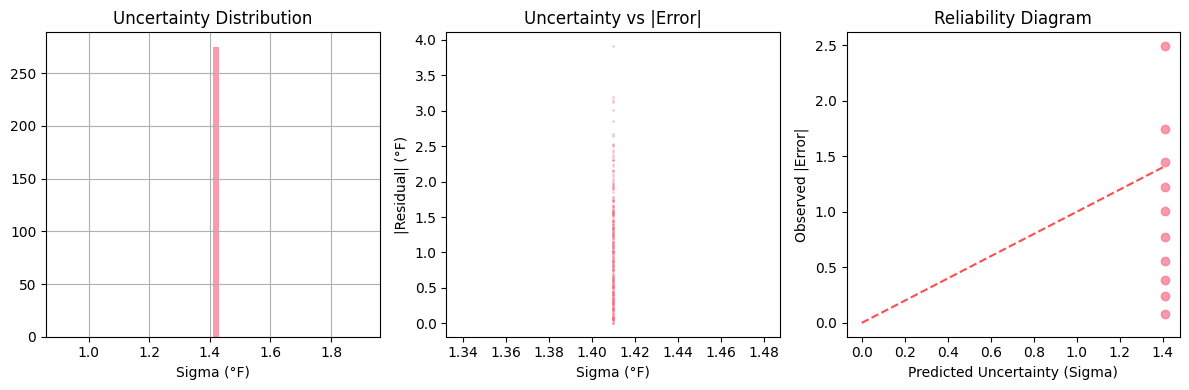

In [28]:
# Calibration analysis
if 'calibration' in metrics:
    cal = metrics['calibration']
    print("=" * 50)
    print("CALIBRATION ANALYSIS")
    print("=" * 50)

    if 'coverage_by_bin' in cal:
        coverage = cal['coverage_by_bin']
        bins = list(coverage.keys())
        observed = [coverage[b]['observed_coverage'] for b in bins]
        expected = [coverage[b]['expected_coverage'] for b in bins]

        plt.figure(figsize=(10, 6))
        plt.plot(expected, observed, 'bo-', alpha=0.7)
        plt.plot([0, 1], [0, 1], 'r--', alpha=0.7, label='Perfect calibration')
        plt.xlabel('Expected Coverage')
        plt.ylabel('Observed Coverage')
        plt.title('Calibration Curve')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.show()

        # Print coverage table
        coverage_df = pd.DataFrame({
            'Bin': bins,
            'Expected': expected,
            'Observed': observed,
            'Difference': [o - e for o, e in zip(observed, expected)]
        })
        display(coverage_df.round(3))

# Uncertainty distribution
if predictions_df is not None and 'sigma' in predictions_df.columns and 'residual' in predictions_df.columns:
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    predictions_df['sigma'].hist(bins=50, alpha=0.7)
    plt.title('Uncertainty Distribution')
    plt.xlabel('Sigma (°F)')

    plt.subplot(1, 3, 2)
    plt.scatter(predictions_df['sigma'], np.abs(predictions_df['residual']), alpha=0.3, s=1)
    plt.title('Uncertainty vs |Error|')
    plt.xlabel('Sigma (°F)')
    plt.ylabel('|Residual| (°F)')

    plt.subplot(1, 3, 3)
    # Reliability diagram
    predictions_df['error_bin'] = pd.qcut(np.abs(predictions_df['residual']), q=10, duplicates='drop')
    reliability = predictions_df.groupby('error_bin')['sigma'].mean()
    error_levels = predictions_df.groupby('error_bin')['residual'].apply(lambda x: np.abs(x).mean())

    plt.scatter(reliability, error_levels, alpha=0.7)
    plt.plot([0, reliability.max()], [0, reliability.max()], 'r--', alpha=0.7)
    plt.title('Reliability Diagram')
    plt.xlabel('Predicted Uncertainty (Sigma)')
    plt.ylabel('Observed |Error|')

    plt.tight_layout()
    plt.show()

## C. Trading Performance

Analyze P&L, drawdown, and trade statistics.

TRADING PERFORMANCE SUMMARY
Total trades: 6
Total PnL:    $-48.54
Return:       -48.5%
Sharpe:       -2.91
Max DD:       $111.01 (111.0%)
Win rate:     50.0%
Avg edge:     6.5%


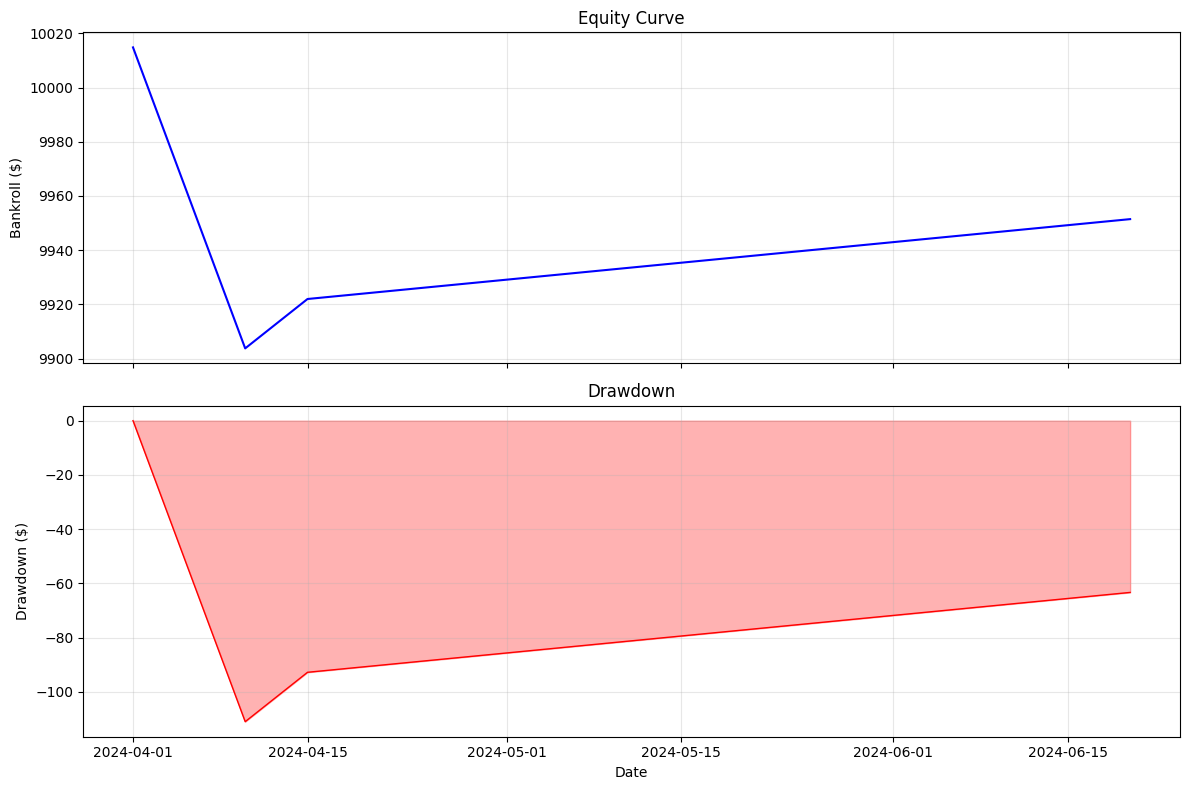

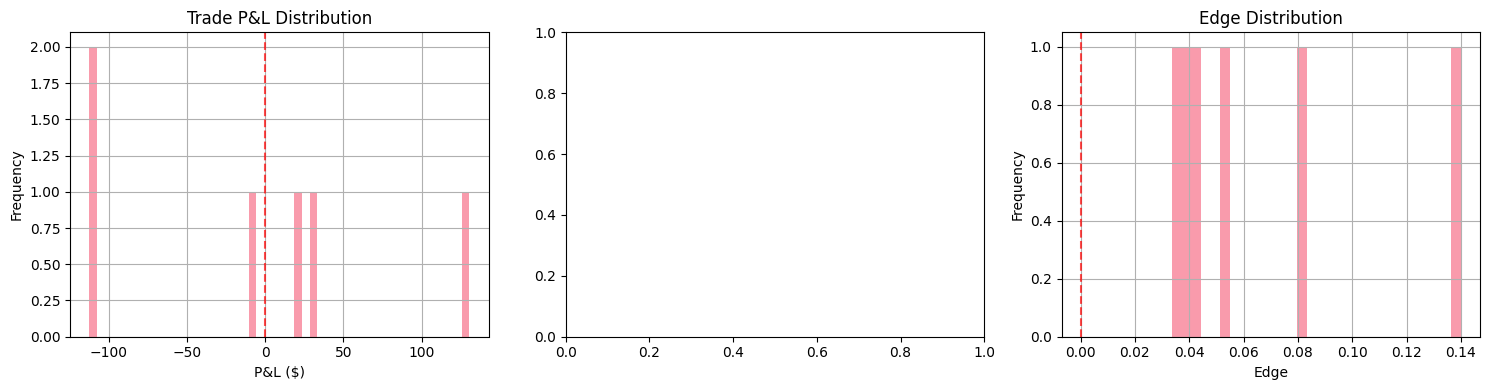


Trade Statistics:
Winning trades: 3
Losing trades:  3
Avg win:        $60.48
Avg loss:       $-76.66
Largest win:    $130.65
Largest loss:   $-112.44


In [29]:
# Trading performance summary
if 'trading' in metrics:
    tr = metrics['trading']
    print("=" * 50)
    print("TRADING PERFORMANCE SUMMARY")
    print("=" * 50)
    print(f"Total trades: {tr.get('n_trades', 'N/A'):,}")
    print(f"Total PnL:    ${tr.get('total_pnl', 'N/A'):,.2f}")
    print(f"Return:       {tr.get('return_pct', 'N/A'):.1%}")
    print(f"Sharpe:       {tr.get('sharpe_ratio', 'N/A'):.2f}")
    print(f"Max DD:       ${tr.get('max_drawdown', 'N/A'):,.2f} ({tr.get('max_drawdown_pct', 'N/A'):.1%})")
    print(f"Win rate:     {tr.get('win_rate', 'N/A'):.1%}")
    print(f"Avg edge:     {tr.get('avg_edge', 'N/A'):.1%}")
    print("=" * 50)

# Equity curve and drawdown
if daily_df is not None and len(daily_df) > 0:
    fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # Equity curve
    axes[0].plot(daily_df['date'], daily_df['bankroll_end'], 'b-', linewidth=1.5)
    axes[0].set_title('Equity Curve')
    axes[0].set_ylabel('Bankroll ($)')
    axes[0].grid(True, alpha=0.3)
    axes[0].ticklabel_format(style='plain', axis='y')

    # Drawdown
    if 'drawdown' in daily_df.columns:
        axes[1].fill_between(daily_df['date'], 0, -daily_df['drawdown'], color='red', alpha=0.3)
        axes[1].plot(daily_df['date'], -daily_df['drawdown'], 'r-', linewidth=1)
        axes[1].set_title('Drawdown')
        axes[1].set_ylabel('Drawdown ($)')
        axes[1].set_xlabel('Date')
        axes[1].grid(True, alpha=0.3)
        axes[1].ticklabel_format(style='plain', axis='y')

    plt.tight_layout()
    plt.show()

# Trade analysis
if trades_df is not None and len(trades_df) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # PnL distribution
    trades_df['pnl'].hist(bins=50, ax=axes[0], alpha=0.7)
    axes[0].axvline(0, color='red', linestyle='--', alpha=0.7)
    axes[0].set_title('Trade P&L Distribution')
    axes[0].set_xlabel('P&L ($)')
    axes[0].set_ylabel('Frequency')

    # Trade size distribution
    if 'position_size' in trades_df.columns:
        trades_df['position_size'].hist(bins=30, ax=axes[1], alpha=0.7)
        axes[1].set_title('Position Size Distribution')
        axes[1].set_xlabel('Position Size ($)')
        axes[1].set_ylabel('Frequency')

    # Edge distribution
    if 'edge' in trades_df.columns:
        trades_df['edge'].hist(bins=30, ax=axes[2], alpha=0.7)
        axes[2].axvline(0, color='red', linestyle='--', alpha=0.7)
        axes[2].set_title('Edge Distribution')
        axes[2].set_xlabel('Edge')
        axes[2].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    # Trade summary stats
    print("\nTrade Statistics:")
    print(f"Winning trades: {len(trades_df[trades_df['pnl'] > 0]):,}")
    print(f"Losing trades:  {len(trades_df[trades_df['pnl'] < 0]):,}")
    print(f"Avg win:        ${trades_df[trades_df['pnl'] > 0]['pnl'].mean():.2f}")
    print(f"Avg loss:       ${trades_df[trades_df['pnl'] < 0]['pnl'].mean():.2f}")
    print(f"Largest win:    ${trades_df['pnl'].max():.2f}")
    print(f"Largest loss:   ${trades_df['pnl'].min():.2f}")

## D. Slicing Analysis

Analyze performance across different dimensions: month, temperature regime, lead hours.

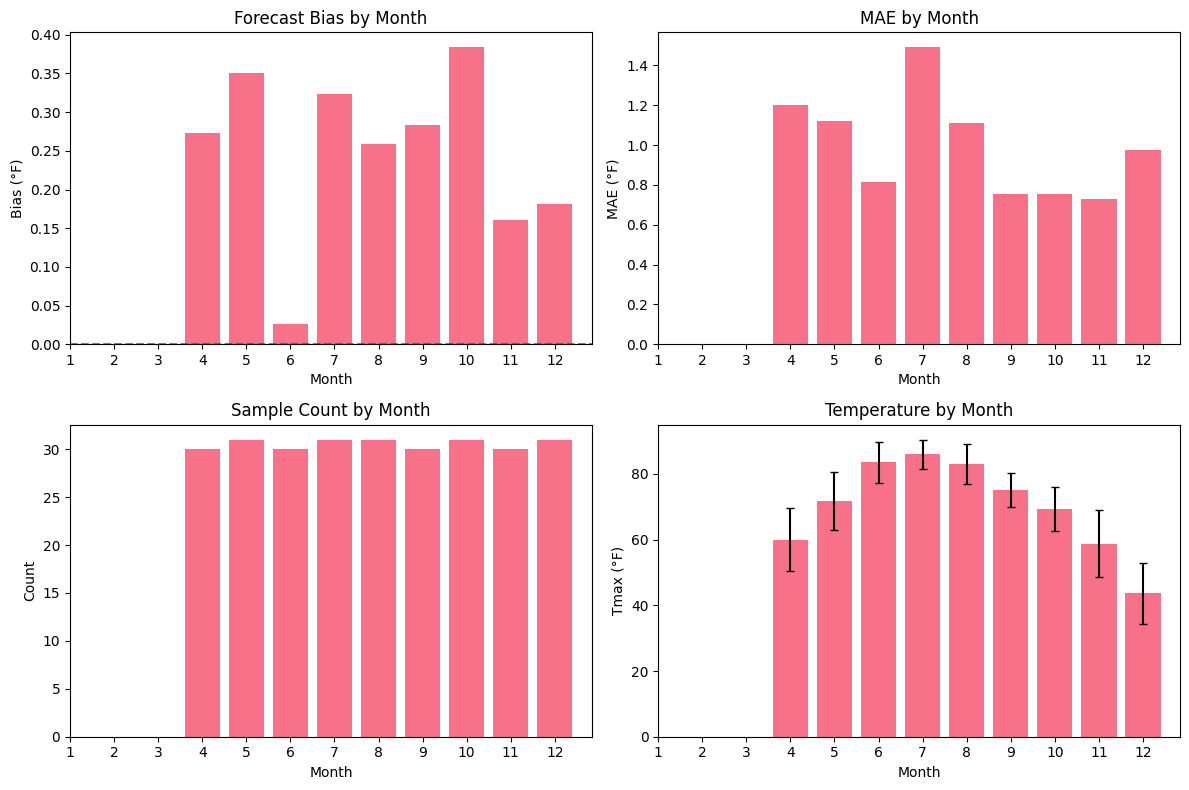

,bias,residual_std,count,mae,rmse
month,,,,,
4,0.273,1.403,30,1.202,1.976
5,0.350,1.354,31,1.121,1.896
6,0.026,1.063,30,0.813,1.094
7,0.323,1.690,31,1.491,2.867
8,0.259,1.349,31,1.110,1.827
9,0.284,0.923,30,0.756,0.904
10,0.384,0.882,31,0.754,0.899
11,0.161,0.847,30,0.731,0.719
12,0.181,1.244,31,0.975,1.530


/var/folders/0b/0y3bh7ms71q9jngg8xbwy36h0000gn/T/ipykernel_61926/479490491.py:89: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  regime_perf = predictions_df.groupby('temp_regime').agg({


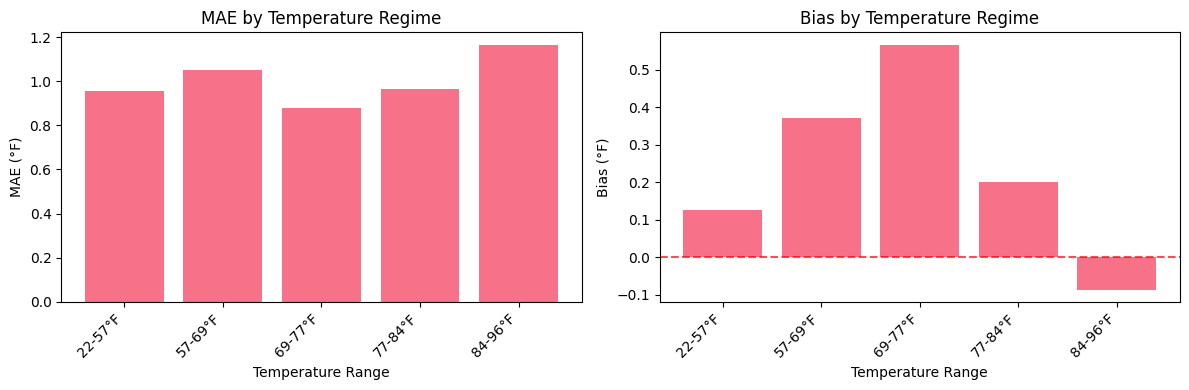

,bias,residual_std,count,mae,rmse
temp_regime,,,,,
"(21.898999999999997, 56.78]",0.126,1.186,55,0.957,1.396
"(56.78, 69.1]",0.372,1.241,58,1.050,1.653
"(69.1, 77.0]",0.567,0.960,58,0.877,1.227
"(77.0, 84.0]",0.200,1.157,57,0.964,1.354
"(84.0, 96.1]",-0.086,1.467,47,1.164,2.114


In [30]:
# Monthly performance
if predictions_df is not None and 'residual' in predictions_df.columns:
    predictions_df['month'] = pd.to_datetime(predictions_df['target_date_local']).dt.month
    monthly_perf = predictions_df.groupby('month').agg({
        'residual': ['mean', 'std', 'count'],
        'mae': 'mean',
        'rmse': 'mean'
    }).round(3)
    monthly_perf.columns = ['bias', 'residual_std', 'count', 'mae', 'rmse']

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    # Monthly bias
    axes[0,0].bar(monthly_perf.index, monthly_perf['bias'])
    axes[0,0].axhline(0, color='red', linestyle='--', alpha=0.7)
    axes[0,0].set_title('Forecast Bias by Month')
    axes[0,0].set_xlabel('Month')
    axes[0,0].set_ylabel('Bias (°F)')
    axes[0,0].set_xticks(range(1, 13))

    # Monthly MAE
    axes[0,1].bar(monthly_perf.index, monthly_perf['mae'])
    axes[0,1].set_title('MAE by Month')
    axes[0,1].set_xlabel('Month')
    axes[0,1].set_ylabel('MAE (°F)')
    axes[0,1].set_xticks(range(1, 13))

    # Sample counts
    axes[1,0].bar(monthly_perf.index, monthly_perf['count'])
    axes[1,0].set_title('Sample Count by Month')
    axes[1,0].set_xlabel('Month')
    axes[1,0].set_ylabel('Count')
    axes[1,0].set_xticks(range(1, 13))

    # Temperature distribution by month (if available)
    if 'tmax_actual_f' in predictions_df.columns:
        monthly_temp = predictions_df.groupby('month')['tmax_actual_f'].agg(['mean', 'std']).round(1)
        axes[1,1].bar(monthly_temp.index, monthly_temp['mean'], yerr=monthly_temp['std'], capsize=3)
        axes[1,1].set_title('Temperature by Month')
        axes[1,1].set_xlabel('Month')
        axes[1,1].set_ylabel('Tmax (°F)')
        axes[1,1].set_xticks(range(1, 13))

    plt.tight_layout()
    plt.show()

    display(monthly_perf)

# Lead hours analysis
if predictions_df is not None and 'lead_hours' in predictions_df.columns and 'residual' in predictions_df.columns:
    lead_perf = predictions_df.groupby('lead_hours').agg({
        'residual': ['mean', 'std', 'count'],
        'mae': 'mean',
        'rmse': 'mean'
    }).round(3)
    lead_perf.columns = ['bias', 'residual_std', 'count', 'mae', 'rmse']

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    axes[0].plot(lead_perf.index, lead_perf['mae'], 'bo-')
    axes[0].set_title('MAE by Lead Hours')
    axes[0].set_xlabel('Lead Hours')
    axes[0].set_ylabel('MAE (°F)')
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(lead_perf.index, lead_perf['bias'], 'ro-')
    axes[1].axhline(0, color='black', linestyle='--', alpha=0.7)
    axes[1].set_title('Bias by Lead Hours')
    axes[1].set_xlabel('Lead Hours')
    axes[1].set_ylabel('Bias (°F)')
    axes[1].grid(True, alpha=0.3)

    axes[2].bar(lead_perf.index, lead_perf['count'])
    axes[2].set_title('Sample Count by Lead Hours')
    axes[2].set_xlabel('Lead Hours')
    axes[2].set_ylabel('Count')

    plt.tight_layout()
    plt.show()

    display(lead_perf)

# Temperature regime analysis
if predictions_df is not None and 'tmax_actual_f' in predictions_df.columns and 'residual' in predictions_df.columns:
    # Create temperature bins
    temp_bins = pd.qcut(predictions_df['tmax_actual_f'], q=5, duplicates='drop')
    predictions_df['temp_regime'] = temp_bins

    regime_perf = predictions_df.groupby('temp_regime').agg({
        'residual': ['mean', 'std', 'count'],
        'mae': 'mean',
        'rmse': 'mean'
    }).round(3)
    regime_perf.columns = ['bias', 'residual_std', 'count', 'mae', 'rmse']

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    regime_labels = [f"{interval.left:.0f}-{interval.right:.0f}°F" for interval in regime_perf.index]

    axes[0].bar(range(len(regime_perf)), regime_perf['mae'])
    axes[0].set_title('MAE by Temperature Regime')
    axes[0].set_xlabel('Temperature Range')
    axes[0].set_ylabel('MAE (°F)')
    axes[0].set_xticks(range(len(regime_labels)))
    axes[0].set_xticklabels(regime_labels, rotation=45, ha='right')

    axes[1].bar(range(len(regime_perf)), regime_perf['bias'])
    axes[1].axhline(0, color='red', linestyle='--', alpha=0.7)
    axes[1].set_title('Bias by Temperature Regime')
    axes[1].set_xlabel('Temperature Range')
    axes[1].set_ylabel('Bias (°F)')
    axes[1].set_xticks(range(len(regime_labels)))
    axes[1].set_xticklabels(regime_labels, rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

    display(regime_perf)

# 7. Multi-Run Comparison

Compare metrics and performance across multiple runs.

In [31]:
# Load multiple runs for comparison
def load_run_data(run_id):
    """Load metrics and key data for a run."""
    run_dir = PROJECT_ROOT / "runs" / run_id
    if not run_dir.exists():
        return None

    try:
        with open(run_dir / "metrics.json") as f:
            metrics = json.load(f)

        daily_df = pd.read_parquet(run_dir / "daily_results.parquet")
        return {
            'run_id': run_id,
            'metrics': metrics,
            'daily_df': daily_df
        }
    except FileNotFoundError:
        return None

# Find available runs
runs_dir = PROJECT_ROOT / "runs"
if runs_dir.exists():
    available_runs = [d.name for d in runs_dir.iterdir() if d.is_dir()]
    print(f"Available runs: {available_runs}")

    # Load multiple runs (modify this list as needed)
    runs_to_compare = available_runs[:3]  # Compare first 3 runs
    run_data = []

    for run_id in runs_to_compare:
        data = load_run_data(run_id)
        if data:
            run_data.append(data)

    if len(run_data) > 1:
        print(f"\nComparing {len(run_data)} runs: {[r['run_id'] for r in run_data]}")

        # Create comparison table
        comparison_data = []
        for run in run_data:
            m = run['metrics']
            row = {
                'Run ID': run['run_id'],
                'MAE': m.get('forecast', {}).get('mae', 'N/A'),
                'Total P&L': m.get('trading', {}).get('total_pnl', 'N/A'),
                'Sharpe': m.get('trading', {}).get('sharpe_ratio', 'N/A'),
                'Win Rate': m.get('trading', {}).get('win_rate', 'N/A'),
                'Max DD %': m.get('trading', {}).get('max_drawdown_pct', 'N/A'),
                'Total Trades': m.get('trading', {}).get('n_trades', 'N/A'),
            }
            comparison_data.append(row)

        comparison_df = pd.DataFrame(comparison_data)
        display(comparison_df)

        # Plot equity curves
        plt.figure(figsize=(12, 6))
        for run in run_data:
            daily_df = run['daily_df']
            if len(daily_df) > 0 and 'date' in daily_df.columns and 'bankroll_end' in daily_df.columns:
                plt.plot(daily_df['date'], daily_df['bankroll_end'], label=run['run_id'], linewidth=2)

        plt.title('Equity Curves Comparison')
        plt.xlabel('Date')
        plt.ylabel('Bankroll ($)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.ticklabel_format(style='plain', axis='y')
        plt.show()

    else:
        print("Need at least 2 runs to compare.")
else:
    print("No runs directory found.")

Available runs: ['20260119_143143']
Need at least 2 runs to compare.


# 8. Diagnostics & Model Validation

Check for overfitting, model stability, and market realism.

In [32]:
# Overfitting diagnostics
if 'diagnostics' in metrics:
    diag = metrics['diagnostics']
    print("=" * 50)
    print("MODEL DIAGNOSTICS")
    print("=" * 50)

    if 'overfitting' in diag:
        of = diag['overfitting']
        print(f"Train MAE:     {of.get('train_mae', 'N/A'):.2f}°F")
        print(f"Val MAE:       {of.get('val_mae', 'N/A'):.2f}°F")
        print(f"Test MAE:      {of.get('test_mae', 'N/A'):.2f}°F")
        print(f"Overfit ratio: {of.get('overfit_ratio', 'N/A'):.2f}")

        if of.get('overfit_ratio', 1) > 1.5:
            print("⚠️  Potential overfitting detected")
        else:
            print("✅ Model appears stable")

    print("=" * 50)

# Feature importance (if available)
if predictions_df is not None and 'residual' in predictions_df.columns:
    # Simple correlation analysis
    feature_cols = [col for col in predictions_df.columns if col.startswith(('sin_doy', 'cos_doy', 'bias_', 'rmse_'))]
    if feature_cols:
        correlations = predictions_df[feature_cols + ['residual']].corr()['residual'].drop('residual')

        plt.figure(figsize=(10, 6))
        correlations.abs().sort_values(ascending=True).plot(kind='barh')
        plt.title('Feature Correlation with Residuals')
        plt.xlabel('|Correlation|')
        plt.grid(True, alpha=0.3)
        plt.show()

        print("\nFeature correlations with residuals:")
        display(correlations.sort_values(key=abs, ascending=False).round(3))

# Market realism checks
if trades_df is not None:
    print("\nMarket Realism Checks:")

    # Check for unrealistic win rates
    win_rate = len(trades_df[trades_df['pnl'] > 0]) / len(trades_df)
    if win_rate > 0.7:
        print(f"⚠️  Very high win rate ({win_rate:.1%}) - check for overfitting")
    elif win_rate < 0.3:
        print(f"⚠️  Very low win rate ({win_rate:.1%}) - may indicate poor edge")
    else:
        print(f"✅ Reasonable win rate ({win_rate:.1%})")

    # Check Sharpe ratio
    if 'trading' in metrics:
        sharpe = metrics['trading'].get('sharpe_ratio', 0)
        if sharpe > 3:
            print(f"⚠️  Unrealistically high Sharpe ({sharpe:.1f}) - check for bugs")
        elif sharpe < 0.5:
            print(f"⚠️  Low Sharpe ({sharpe:.1f}) - poor risk-adjusted returns")
        else:
            print(f"✅ Reasonable Sharpe ({sharpe:.1f})")

    # Check for position concentration
    if 'position_size' in trades_df.columns:
        max_position = trades_df['position_size'].max()
        mean_position = trades_df['position_size'].mean()
        concentration = max_position / mean_position
        if concentration > 10:
            print(f"⚠️  High position concentration (max/mean = {concentration:.1f}) - check risk management")
        else:
            print(f"✅ Reasonable position sizing (max/mean = {concentration:.1f})")


Market Realism Checks:
✅ Reasonable win rate (50.0%)
⚠️  Low Sharpe (-2.9) - poor risk-adjusted returns


# 9. Export Analysis Results

Save plots and analysis results outside the run directory.

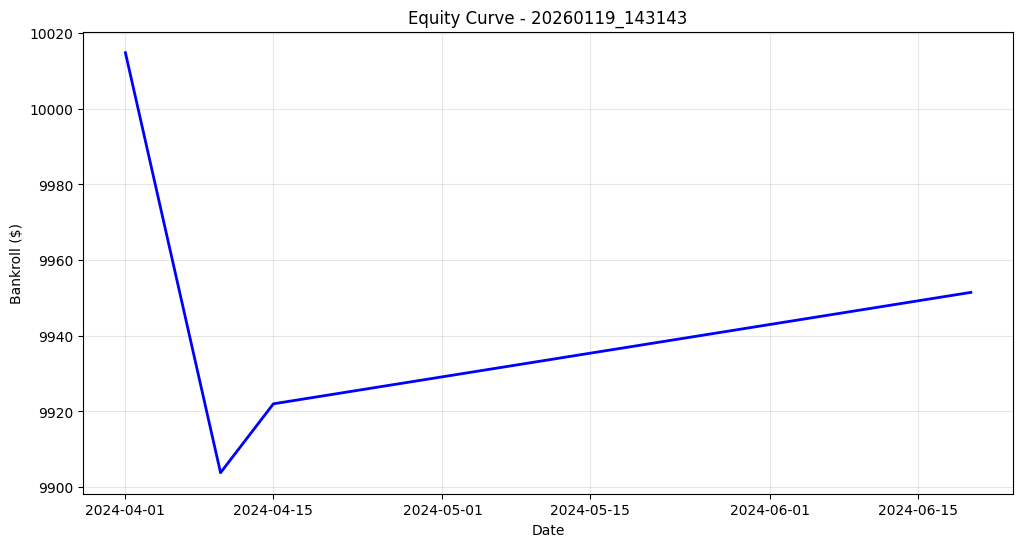

✅ Saved equity curve: /Users/kcao/Documents/temp-data-pipeline/figures/equity_curve_20260119_143143_20260119_143146.png
✅ Saved analysis summary: /Users/kcao/Documents/temp-data-pipeline/figures/analysis_summary_20260119_143143_20260119_143146.txt

All analysis artifacts saved to: /Users/kcao/Documents/temp-data-pipeline/figures


In [33]:
# Create figures directory
figures_dir = PROJECT_ROOT / "figures"
figures_dir.mkdir(exist_ok=True)

# Export key plots
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Example: Save equity curve
if daily_df is not None and len(daily_df) > 0:
    plt.figure(figsize=(12, 6))
    plt.plot(daily_df['date'], daily_df['bankroll_end'], 'b-', linewidth=2)
    plt.title(f'Equity Curve - {RUN_ID}')
    plt.xlabel('Date')
    plt.ylabel('Bankroll ($)')
    plt.grid(True, alpha=0.3)
    plt.ticklabel_format(style='plain', axis='y')

    equity_path = figures_dir / f"equity_curve_{RUN_ID}_{timestamp}.png"
    plt.savefig(equity_path, dpi=150, bbox_inches='tight')
    plt.show()

    print(f"✅ Saved equity curve: {equity_path}")

# Save analysis summary
summary_path = figures_dir / f"analysis_summary_{RUN_ID}_{timestamp}.txt"
with open(summary_path, 'w') as f:
    f.write(f"Analysis Summary for Run: {RUN_ID}\n")
    f.write(f"Generated: {datetime.now()}\n\n")

    if 'forecast' in metrics:
        fc = metrics['forecast']
        f.write("FORECAST PERFORMANCE:\n")
        f.write(f"  MAE: {fc.get('mae', 'N/A'):.2f}°F\n")
        f.write(f"  RMSE: {fc.get('rmse', 'N/A'):.2f}°F\n")
        f.write(f"  Bias: {fc.get('bias', 'N/A'):+.2f}°F\n")
        f.write(f"  90% PI Coverage: {fc.get('coverage_90', 'N/A'):.1%}\n\n")

    if 'trading' in metrics:
        tr = metrics['trading']
        f.write("TRADING PERFORMANCE:\n")
        f.write(f"  Total P&L: ${tr.get('total_pnl', 'N/A'):,.2f}\n")
        f.write(f"  Return: {tr.get('return_pct', 'N/A'):.1%}\n")
        f.write(f"  Sharpe: {tr.get('sharpe_ratio', 'N/A'):.2f}\n")
        f.write(f"  Win Rate: {tr.get('win_rate', 'N/A'):.1%}\n")
        f.write(f"  Max Drawdown: {tr.get('max_drawdown_pct', 'N/A'):.1%}\n")

print(f"✅ Saved analysis summary: {summary_path}")
print(f"\nAll analysis artifacts saved to: {figures_dir}")